# Imports

In [51]:
!pip install pyod


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.lof import LOF

from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import pdist, squareform

from mpl_toolkits.mplot3d import Axes3D

from itertools import chain, combinations

# Data

In [90]:
df_train = pd.read_csv("/Users/Giacomo/Desktop/DM2/PRJ/df_train_processed.csv")
df_test = pd.read_csv("/Users/Giacomo/Desktop/DM2/PRJ/df_test_processed.csv")

In [91]:
print(df_train.shape, df_test.shape)

(1828, 385) (624, 385)


In [92]:
df_train_num = df_train.select_dtypes(include="number").drop(["actor", "Unnamed: 0"], axis=1)
df_test_num = df_test.select_dtypes(include="number").drop(["actor", "Unnamed: 0"], axis=1)

In [93]:
print(df_train_num.shape, df_test_num.shape)

(1828, 376) (624, 376)


### Standardization

In [94]:
scaler = MinMaxScaler()
df_train_num_scal = scaler.fit_transform(df_train_num)
df_test_num_scal = scaler.fit_transform(df_test_num)
df_train_num = pd.DataFrame(df_train_num_scal, columns=df_train_num.columns)
df_test_num = pd.DataFrame(df_test_num_scal, columns=df_test_num.columns)

### Feature reduction

In [95]:
pca = PCA(3)
df_train_pca = pca.fit_transform(df_train_num)
df_test_pca = pca.fit_transform(df_test_num)

# Functions

In [96]:
def get_top_scores(decision_scores, percentage, higher_is_outlier=True, show_index=False):
    """Returns the top scores (in the percentage indicated). If show_index = True,
    returns only the correspondent indexes. If higher_is_outlier=False, then lower the score, higher the
    outlierness"""
    n_items = int(np.ceil((percentage * len(decision_scores)) / 100))
    dic = {}
    for index, score in enumerate(decision_scores):
        dic[score] = index
    if higher_is_outlier:
        top_scores = sorted(decision_scores, reverse=True)[:n_items]
    else:
        top_scores = sorted(decision_scores)[:n_items]
    if show_index == True:
        return [dic[score] for score in top_scores]
    return top_scores

In [97]:
def powerset(iterable):
    "Returns the powerset of an iterable"
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [98]:
def inter(first, *others):
    "Returns the intersection between more sets"
    return set(first).intersection(*others)

## HBOS

In [99]:
clf = HBOS(contamination=0.01)
clf.fit(df_train_num)

HBOS(alpha=0.1, contamination=0.01, n_bins=10, tol=0.5)

In [100]:
outliers = clf.predict(df_train_num)

In [101]:
indexes_hbos = [index for index, value in enumerate(outliers) if value == 1]

In [102]:
len(indexes_hbos)

19

# EllEnv

### Train

In [103]:
ellenv = EllipticEnvelope(random_state=0, contamination=0.01)
ellenv.fit(df_train_num)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


EllipticEnvelope(contamination=0.01, random_state=0)

In [104]:
outliers_train = ellenv.predict(df_train_num)

In [105]:
np.unique(outliers_train, return_counts=True)

(array([-1,  1]), array([  19, 1809]))

In [106]:
indexes_train_eenv = [index for index, value in enumerate(outliers_train) if value ==-1]

In [107]:
len(indexes_train_eenv)

19

### Test

In [108]:
ellenv = EllipticEnvelope(random_state=0)
ellenv.fit(df_test_num)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


EllipticEnvelope(random_state=0)

In [109]:
outliers_test = ellenv.predict(df_test_num)

In [110]:
np.unique(outliers_test, return_counts=True)

(array([-1,  1]), array([ 63, 561]))

In [111]:
63 / 561

0.11229946524064172

# Deviation-Based

In [112]:
def sf(x, X):
    idx = list(X).index(x)
    X1 = np.array([x1 for i, x1 in enumerate(X) if i != idx])
    return np.abs(np.var(X) - np.var(X1))

# if the variance of X1 is lowered, then the point is an outlier. 
# quindi tanto più grande è lo scarto, tanto più il punto è un outlier.

In [113]:
scores = {}
counter = 0
for var in df_train_num:
    print(counter)
    for index, value in enumerate(df_train_num[var]):
        score = sf(value, df_train_num[var])
        scores[score] = index
    counter += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [114]:
top_scores = get_top_scores(list(scores.keys()), 10)[:19]
indexes_train_dev = [scores[score] for  score in top_scores]

# KNN

### Train

In [115]:
clf = KNN(n_neighbors=5)
clf.fit(df_train_pca)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [116]:
scores_train_knn = get_top_scores(clf.decision_scores_, 1)

In [117]:
indexes_train_knn = get_top_scores(clf.decision_scores_, 1, show_index=True)

### Test

In [118]:
clf = KNN(n_neighbors=5)
clf.fit(df_test_pca)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [119]:
scores_test_knn = get_top_scores(clf.decision_scores_, 1)

In [120]:
indexes_test_knn = get_top_scores(clf.decision_scores_, 1, show_index=True)

# LOF

### Train

In [121]:
clf = LOF()
clf.fit(df_train_pca)

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [122]:
scores_train_lof = get_top_scores(clf.decision_scores_, 1)

In [123]:
indexes_train_lof = get_top_scores(clf.decision_scores_, 1, show_index=True)

### Test

In [124]:
clf = LOF()
clf.fit(df_test_pca)

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [125]:
scores_test_lof = get_top_scores(clf.decision_scores_, 1)

In [126]:
indexes_test_lof = get_top_scores(clf.decision_scores_, 1, show_index=True)

## DBSCAN

In [127]:
dist = pdist(df_train_pca, 'euclidean')
dist = squareform(dist) 

In [128]:
k=12
kth_distances = []
for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

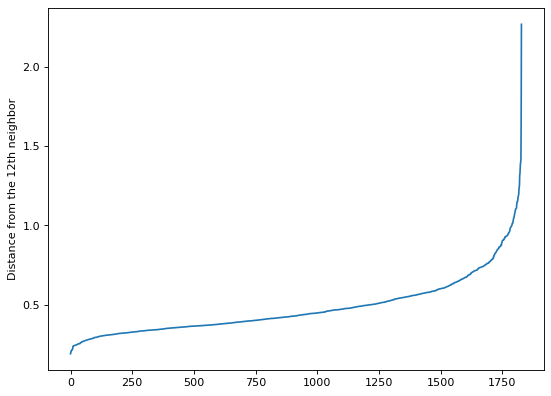

In [129]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('Distance from the {}th neighbor'.format(k))
#pltaxvline()
plt.show() # we plot the distances sorted by distance

In [130]:
dbscan = DBSCAN(eps=0.85, min_samples=12)
dbscan.fit(df_train_pca)

DBSCAN(eps=0.85, min_samples=12)

In [131]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([  19, 1809]))

In [132]:
indexes_dbscan = list(pd.DataFrame(df_train_pca).loc[np.where(dbscan.labels_==-1)].index)

# Comparison

In [133]:
index_dict = {"LOF": indexes_train_lof, 
              "KNN": indexes_train_knn, 
              "DB": indexes_train_dev, 
              "HBOS": indexes_hbos,
              "EE": indexes_train_eenv,
              "DBSCAN": indexes_dbscan}

In [134]:
print(len(indexes_hbos), len(indexes_train_dev), 
      len(indexes_train_lof), len(indexes_train_knn), 
      len(indexes_train_eenv), len(indexes_dbscan))

19 19 19 19 19 19


In [135]:
sets = powerset([indexes_train_lof, 
                 indexes_train_knn, 
                 indexes_train_dev, 
                 indexes_hbos, 
                 indexes_train_eenv, 
                 indexes_dbscan])
sets = [list(item) for item in sets]

In [136]:
intersections = {}
for item in sets:
    if len(item) == 2:
        intersection = inter(item[0], item[1])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key = key1 + "-" + key2
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 3:
        intersection = inter(item[0], item[1], item[2])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key = key1 + "-" + key2 + "-" + key3
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 4:
        intersection = inter(item[0], item[1], item[2], item[3])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 5:
        intersection = inter(item[0], item[1], item[2], item[3], item[4])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key5 = list(index_dict.keys())[list(index_dict.values()).index(item[4])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4 + "-" + key5
        intersections[key] = round(len(intersection) / len(item[0]), 2)
    elif len(item) == 6:
        intersection = inter(item[0], item[1], item[2], item[3], item[4], item[5])
        key1 = list(index_dict.keys())[list(index_dict.values()).index(item[0])]
        key2 = list(index_dict.keys())[list(index_dict.values()).index(item[1])]
        key3 = list(index_dict.keys())[list(index_dict.values()).index(item[2])]
        key4 = list(index_dict.keys())[list(index_dict.values()).index(item[3])]
        key5 = list(index_dict.keys())[list(index_dict.values()).index(item[4])]
        key6 = list(index_dict.keys())[list(index_dict.values()).index(item[5])]
        key = key1 + "-" + key2 + "-" + key3 + "-" + key4 + "-" + key5 + "-" + key6
        intersections[key] = round(len(intersection) / len(item[0]), 2)

In [137]:
intersections

{'LOF-KNN': 0.26,
 'LOF-DB': 0.11,
 'LOF-HBOS': 0.11,
 'LOF-EE': 0.05,
 'LOF-DBSCAN': 0.21,
 'KNN-DB': 0.05,
 'KNN-HBOS': 0.32,
 'KNN-EE': 0.16,
 'KNN-DBSCAN': 0.79,
 'DB-HBOS': 0.05,
 'DB-EE': 0.21,
 'DB-DBSCAN': 0.0,
 'HBOS-EE': 0.0,
 'HBOS-DBSCAN': 0.32,
 'EE-DBSCAN': 0.05,
 'LOF-KNN-DB': 0.05,
 'LOF-KNN-HBOS': 0.11,
 'LOF-KNN-EE': 0.05,
 'LOF-KNN-DBSCAN': 0.21,
 'LOF-DB-HBOS': 0.0,
 'LOF-DB-EE': 0.05,
 'LOF-DB-DBSCAN': 0.0,
 'LOF-HBOS-EE': 0.0,
 'LOF-HBOS-DBSCAN': 0.11,
 'LOF-EE-DBSCAN': 0.0,
 'KNN-DB-HBOS': 0.0,
 'KNN-DB-EE': 0.05,
 'KNN-DB-DBSCAN': 0.0,
 'KNN-HBOS-EE': 0.0,
 'KNN-HBOS-DBSCAN': 0.32,
 'KNN-EE-DBSCAN': 0.05,
 'DB-HBOS-EE': 0.0,
 'DB-HBOS-DBSCAN': 0.0,
 'DB-EE-DBSCAN': 0.0,
 'HBOS-EE-DBSCAN': 0.0,
 'LOF-KNN-DB-HBOS': 0.0,
 'LOF-KNN-DB-EE': 0.05,
 'LOF-KNN-DB-DBSCAN': 0.0,
 'LOF-KNN-HBOS-EE': 0.0,
 'LOF-KNN-HBOS-DBSCAN': 0.11,
 'LOF-KNN-EE-DBSCAN': 0.0,
 'LOF-DB-HBOS-EE': 0.0,
 'LOF-DB-HBOS-DBSCAN': 0.0,
 'LOF-DB-EE-DBSCAN': 0.0,
 'LOF-HBOS-EE-DBSCAN': 0.0,
 'KNN-DB-

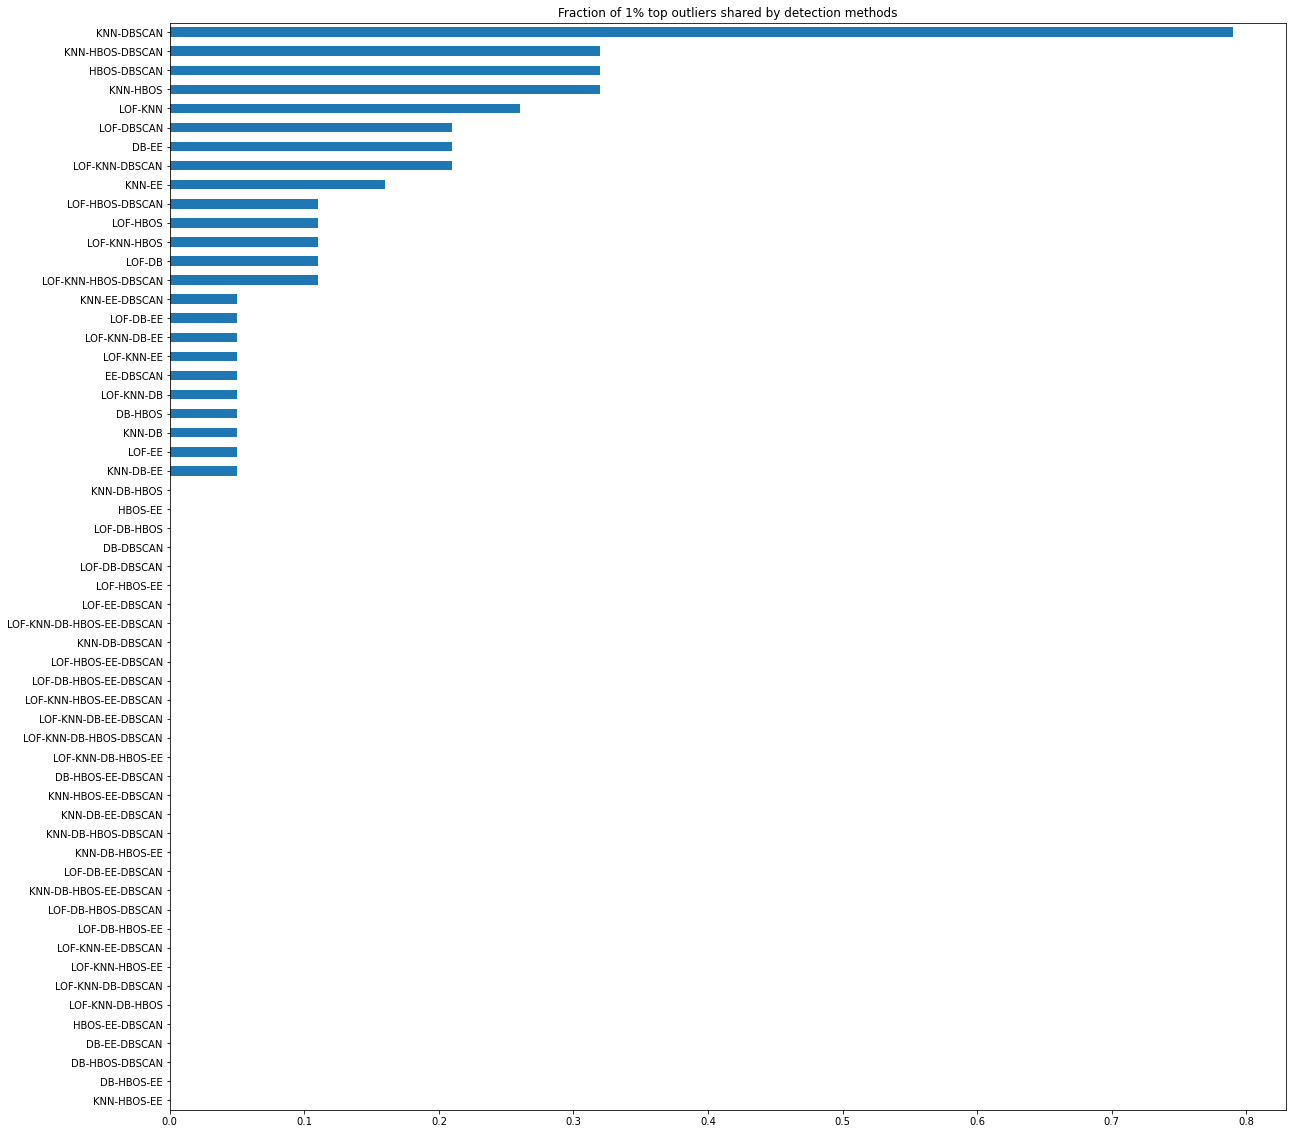

In [141]:
plt.rcParams["figure.figsize"] = (20, 20)
data = pd.DataFrame(intersections, index=[0]).T.sort_values(by=0)
ax = data.plot(kind="barh")
plt.title("Fraction of 1% top outliers shared by detection methods")
ax.get_legend().remove()
plt.show()